# Data 602:  Homework 11
##### Author: Aaron Grzasko
##### Date: 5/5/2017


## Assignment Overview  
Perform a Monte Carlo simulation to calculate Value at Risk (VaR) for the Apple stock price using the file attached to this lesson. There exist a number of ways to do this type of analysis, but you can follow this basic procedure (refer to this PDF [mc.pdf](https://github.com/spitakiss/DATA602_Work/blob/master/Homework11/mc.pdf) for a more rigorous mathematical overview).

## Part 1  
(1) The file, apple.2011.csv, has 3 columns: date, price, and percent change.  The information you are really interested in is the percent change.  This value is the percent change in the price from the previous date to the date on the corresponding row.


In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# read in data
apple_url = 'https://raw.githubusercontent.com/spitakiss/DATA602_Work/master/Homework11/apple.2011.csv'
apple = pd.read_csv(apple_url, na_values="XXXXX")

In [3]:
# rename third colum 
apple.rename(columns={'Unnamed: 2':'pchg'}, inplace=True)

In [4]:
# view first rows of data set
apple.head()

,Date,Last,pchg
0,1/3/2011,329.57,NaN
1,1/4/2011,331.29,0.005219
2,1/5/2011,334.00,0.008180
3,1/6/2011,333.73,-0.000808
4,1/7/2011,336.12,0.007161


In [5]:
# summary statistics of price and daily return
apple.describe()

,Last,pchg
count,252.000000,251.000000
mean,364.004302,0.000957
std,25.923816,0.016521
min,315.320000,-0.055940
25%,342.217500,-0.009283
50%,357.025000,0.001008
75%,388.150000,0.011065
max,422.240000,0.058888


## Parts 2 and 3 
(2) Use the percent change values to create a Gaussian random number generator.  This generator will create Gaussian-distributed randoms to use as hypothetical percent changes on the day to day price of Apple stock. 

(3) With that generator, create 20 random numbers.  With these randoms, you can find a potential price change over 20 days.



In [6]:
# mean daily return
mean_ret = apple['pchg'].mean()
round(mean_ret,6)

0.000957

In [7]:
# std deviation of daily return
std_ret = apple['pchg'].std()
round(std_ret,6)

0.016521

In [8]:
# random number generator, size 20 assuming normal distribution
# using historical return mean and std deviation as parameters
np.random.seed(1)
myrand = np.random.normal(loc=mean_ret,scale=std_ret,size=20)
myrand

array([ 0.02779244, -0.0091492 , -0.00776834, -0.01676868,  0.01525437,
       -0.03706534,  0.02978262, -0.01161821,  0.00622806, -0.00316238,
        0.02511219, -0.03307732, -0.00436916, -0.00538744,  0.01968786,
       -0.01721346, -0.00189125, -0.01354535,  0.00165475,  0.01058579])

## Parts 4 and 5
(4) Start with the price from the last row and the random numbers to determine a hypothetical price after 20 days.  To do this, take that last price, apply a percent change and get a new price.  Then take that new price, and apply the next percent change.  Do this for the 20 randoms, and get a final price.  
 
(5) Store the final price after 20 days (you can discard the intermediate price values).


In [9]:
# starting stock price
p0 = float(apple["Last"].iloc[-1:])
p0

405.0

In [10]:
# price after 20 days, using stochastically generated daily returns
p20 = np.prod(myrand + 1) * p0
round(p20,2)

393.72

## Part 6
(6) Repeat steps 3-5 a very large number of times.  Something like 10,000.  Each run will yield a different result.

*Let's first formalize steps 2-5 above using a stock price generating function:*

In [11]:
# stochastic stock price generation using gaussian-distributed daily returns 
# inputs:  starting stock price, number of days, mean daily return, std dev daily return
def price_gen(beg_price, days, mean, std):
    return beg_price * np.prod(np.random.normal(loc=mean,scale=std,size=days)+1)

# example output using price_gen function
np.random.seed(1)
round(price_gen(p0,20,mean_ret,std_ret),2)


393.72

*Now let's generate 10,000 simulations of the stock price after 20 days:*

In [12]:
np.random.seed(1)

# simulate stock prices 
# inputs: number of simulations, price generating function passed as string
def sim_stock(num_sims,price_func):
    sim_result = []
    for i in range(num_sims):
        sim_result.append(round(eval(price_func),2))
        
    return sim_result

# first 10 reslts of simulation
my_sim = sim_stock(10000,"price_gen(p0,20,mean_ret,std_ret)")
my_sim[:10]

[393.72, 405.91, 440.77, 435.81, 427.05, 400.25, 428.1, 433.35, 439.8, 466.78]

Here is a histogram of the simulated stock prices after 20 trading days.  

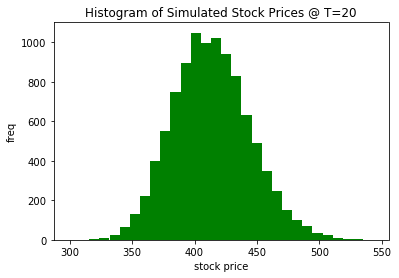

In [13]:
# plot histogram of data
plt.hist(my_sim,30, normed=0, histtype='bar', color='green')

# formatting
plt.xlabel('stock price')
plt.ylabel('freq')
plt.title('Histogram of Simulated Stock Prices @ T=20')
plt.show()

## Part 7
(7) Take all of the stored prices (10,000 or so), sort them, and find the 1% lowest percentile.  This value is the final result, and represents the VaR with 99% confidence.  This means that the price will be above this result after 20 days with a confidence level of 99%.


*Percentiles can be calculated in a variety of ways.  Here we'll use the percentile as given by the np.percentile() function.  This function uses the following formula:*   
$$ i = p(N-1) + 1$$  
*where $p \in [0,1]$ is the percentile of interest, $N$ is the sample size,  and $i \in [1,N]$ refers to the i-th entry in the sorted data set. Linear interpolation is used to determine percentile values in cases where x is not an integer value.* 

In [14]:
# identify lowest 1%.
# This is VaR with 99% confidence
var99 = np.percentile(my_sim,1)
var99

347.589

Finally, let's replot the histogram with the VaR threshold clearly demarcated.  

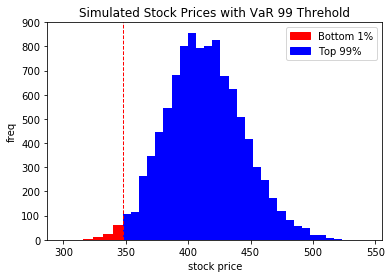

In [15]:
# plot histogram of data with visual distinction at VaR threshold
plt.hist(np.array(my_sim)[my_sim > var99],30, normed=0, histtype='bar', color='blue')
plt.hist(np.array(my_sim)[my_sim <= var99],6, normed=0, histtype='bar', color='red')


# format plot
plt.axvline(x=var99, color='r', linestyle='dashed', linewidth=1)
plt.xlabel('stock price')
plt.ylabel('freq')
plt.title('Simulated Stock Prices with VaR 99 Threhold')
red_patch = mpatches.Patch(color='red', label='Bottom 1%')
blue_patch = mpatches.Patch(color='blue', label='Top 99%')
plt.legend(handles = [red_patch, blue_patch])
plt.show()